### COVID-19 Prediction

## Data

https://opendata.ecdc.europa.eu/covid19/casedistribution/csv

In [1]:
import pandas as pd
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
import codebase
from codebase.data_generation import *
from codebase.sparse_regression import *
from codebase.utils import *

def logistic(t, a, b, c):
    return a/(1 + np.exp(b*(t - c)))

def synchronize(weights, data, derivative=False, precision=0.00001):
    def half(a, b):
        return (a + b)/2
    a = 1e-20
    b = 1
    t = range(len(data))
    # plt.plot(data, 'k.')
    def _inte(d):
        return (data - integrate(weights, [d], t, derivative=derivative)).mean()
    while b-a > precision:
        guess_a = _inte(a)
        guess_b = _inte(b)
        c = half(a, b)
        # plt.plot(integrate(weights, [a], t, derivative=derivative))
        guess_c = _inte(c)
        if guess_a * guess_c > 0:
            a = c
        else:
            b = c
    # plt.show()
    return c

def find_beginning(values):
    for i, val in enumerate(values):
        if val > 10:
            return i
    return 0

raw_data = pd.read_csv('https://ocgptweb.azurewebsites.net/CSVDownload', parse_dates=['Date'])

In [3]:
original_data = raw_data.sort_values(['CountryCode', 'Date']).copy()
first_values = original_data.sort_values(['CountryCode', 'Date'])['CountryCode'].drop_duplicates()
today_values = original_data[original_data['Date'].dt.date == pd.Timestamp.today().date()]
original_data = original_data[['CountryName', 'CountryCode', 'Date', 'ConfirmedCases', 'ConfirmedDeaths', 'StringencyIndexForDisplay']].drop(today_values.index)
original_data.loc[first_values.index] = 0
original_data = original_data.fillna(method='bfill')
for country in original_data['CountryCode'].unique():
    tmp = original_data.loc[original_data['CountryCode'] == country]['StringencyIndexForDisplay']
    tmp = tmp.shift(periods=10, fill_value=0)
    original_data.loc[original_data['CountryCode'] == country, 'ShiftedStringency'] = tmp

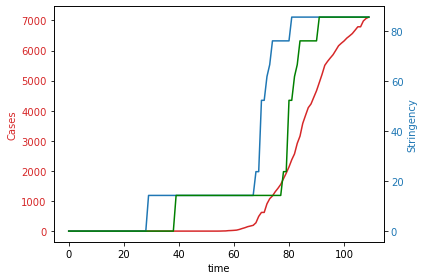

In [4]:
country_data = original_data[original_data['CountryCode'] == 'NOR'].copy()
values = country_data.sort_values('Date')[['ConfirmedCases']].values[1:]

rescaling = 100

t = range(len(values))
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('time')
ax1.set_ylabel('Cases', color=color)
ax1.plot(t, values[:, 0], label='cases', color=color)
# ax1.plot(t, values[:, 1], label='deaths', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Stringency', color=color)
ax2.plot(t, country_data['StringencyIndexForDisplay'].iloc[:-1], color=color)
ax2.plot(t, country_data['ShiftedStringency'].iloc[:-1], color='green')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()

values = values/rescaling

In [5]:
dm, m = make_targets(values, derivative=False)
derivatives, m = make_targets(values, deriv:=True)
X, _ = make_polynomials(m, max_degree=3)
dweights, _ = sparse_regression(X, derivatives[:, 0].reshape(-1, 1), cutoff=1e-4)
weights, _ = sparse_regression(X, dm[:, 0].reshape(-1, 1), cutoff=1e-4)

show_weights(dweights, derivative=True)
show_weights(weights, derivative=False)

| function   |   $\dot{x}$ |
|:-----------|------------:|
| $1$        |   0.0513982 |
| $ x$       |   0.143147  |
| $ x^2$     |  -0.0019772 |
| $ x^3$     |   0         |

| function   |   $x_{k+1}$ |
|:-----------|------------:|
| $1$        |  0.0639405  |
| $ x$       |  1.14455    |
| $ x^2$     | -0.00201744 |
| $ x^3$     |  0          |

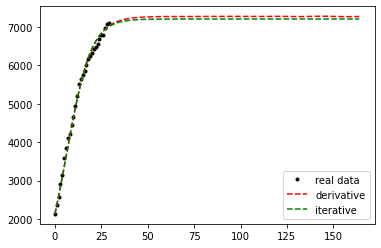

In [6]:

nb_values = len(values)
extrapolation = int(nb_values*1.5)
t = np.arange(0, extrapolation)

popt, pcov = curve_fit(logistic, t[:nb_values], values[:, 0], maxfev=10000)
guess = integrate(weights, [values[80][0]], t, derivative=False)
dguess = integrate(dweights, [values[80][0]], t, derivative=True)
plt.plot(values[80:, 0]*rescaling, 'k.', label='real data')
plt.plot(dguess*rescaling, 'r--', label='derivative')
plt.plot(guess*rescaling, 'g--', label='iterative')
# plt.plot(t, logistic(t, *popt)*backscaling, 'b--', label='logistic fit')
plt.legend()
plt.show()

In [7]:
synchronize(weights, values)

0.9999923706054688

## Data collection

For this approach I decided to use a few indicators for each country, like total population, HDI, lattitude of the capital city.

### Countries

In [8]:
countries = {country: iso for _, (country, iso) in original_data[['CountryName', 'CountryCode']].iterrows() if type(country) == str and iso not in ['RKS']}

### Indicators

In [12]:
import requests
import json

isos = ";".join([iso.lower() for _, iso in countries.items()][:-1])

indicators_description = {'SH.MED.BEDS.ZS': 'Hospital beds (per 1,000 people)',
                         'SH.MED.PHYS.ZS': 'Physicians (per 1,000 people)',
                         'SH.MED.NUMW.P3': 'Nurses and midwives (per 1,000 people)',
                         'SH.UHC.SRVS.CV.XD': 'UHC service coverage index',
                         'SH.XPD.CHEX.GD.ZS': 'Current health expenditure (% of GDP)',
                         'SH.XPD.CHEX.PC.CD': 'Current health expenditure per capita (current US$)',
                         'SH.XPD.CHEX.PP.CD': 'Current health expenditure per capita, PPP (current international $)',
                         'SH.XPD.OOPC.CH.ZS': 'Out-of-pocket expenditure (% of current health expenditure)',
                         'SH.XPD.OOPC.PC.CD': 'Out-of-pocket expenditure per capita (current US$)',
                         'SH.XPD.OOPC.PP.CD': 'Out-of-pocket expenditure per capita, PPP (current international $)',
                         'SH.STA.DIAB.ZS': 'Diabetes prevalence (% of population ages 20 to 79)',
                         'SP.DYN.LE00.FE.IN': 'Life expectancy at birth, female (years)',
                         'SP.DYN.LE00.IN': 'Life expectancy at birth, total (years)',
                         'SP.DYN.LE00.MA.IN': 'Life expectancy at birth, male (years)',
                         'SP.DYN.AMRT.FE': 'Mortality rate, adult, female (per 1,000 female adults)',
                         'SP.DYN.AMRT.MA': 'Mortality rate, adult, male (per 1,000 male adults)',
                         'SH.DYN.NCOM.ZS': 'Mortality from CVD, cancer, diabetes or CRD between exact ages 30 and 70 (%)',
                         'SH.DYN.NCOM.FE.ZS': 'Mortality from CVD, cancer, diabetes or CRD between exact ages 30 and 70, female (%)',
                         'SH.DYN.NCOM.MA.ZS': 'Mortality from CVD, cancer, diabetes or CRD between exact ages 30 and 70, male (%)',
                         'SH.DTH.COMM.ZS': 'Cause of death, by communicable diseases and maternal, prenatal and nutrition conditions (% of total)',
                         'SH.DTH.INJR.ZS': 'Cause of death, by injury (% of total)',
                         'SH.DTH.NCOM.ZS': 'Cause of death, by non-communicable diseases (% of total)',
                         'SH.H2O.BASW.ZS': 'People using at least basic drinking water services (% of population)',
                         'SH.STA.BASS.ZS': 'People using at least basic sanitation services (% of population)',
                         'SP.POP.80UP.FE.5Y': 'Population ages 80 and above, female (% of female population)',
                         'SP.POP.80UP.MA.5Y': 'Population ages 80 and above, male (% of male population)',
                         'SP.POP.65UP.FE.ZS': 'Population ages 65 and above, female (% of total)',
                         'SP.POP.65UP.MA.ZS': 'Population ages 65 and above, male (% of total)',
                         'SP.POP.65UP.TO.ZS': 'Population ages 65 and above (% of total)',
                         'SP.POP.0014.FE.ZS': 'Population ages 0-14, female (% of female population)',
                         'SP.POP.0014.MA.ZS': 'Population ages 0-14, male (% of male population)',
                         'SP.POP.0014.TO.ZS': 'Population ages 0-14 (% of total population)',
                         'SP.POP.1564.FE.ZS': 'Population ages 15-64, female (% of female population)',
                         'SP.POP.1564.MA.ZS': 'Population ages 15-64, male (% of male population)',
                         'SP.POP.1564.TO.ZS': 'Population ages 15-64 (% of total population)',
                         'SP.POP.TOTL': 'Total population'}

indicators = indicators_description.keys()

result = {country: [] for _, country in countries.items()}
for indicator in tqdm(indicators):
    URL = f"https://api.worldbank.org/v2/country/{isos}/indicators/{indicator}"
    PARAMS = {'mrnev':1, 'format':'json', 'per_page': 150}
    try:
        r = requests.get(url=URL, params=PARAMS)
        done = []
#         missing = []
        for country in r.json()[1]:
            result[country['countryiso3code']].append(country['value'])
            done.append(country['countryiso3code'])
        for _, country in countries.items():
            if country not in done:
                result[country].append(np.nan)
#                 missing.append(country)
#         print(indicator, missing)
                
    except json.JSONDecodeError:
        print(f'Could not retreive info for indicator {indicator}')

100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:30<00:00,  1.20it/s]


In [13]:
hdis = {'ABW': np.nan, 'AFG': 0.496, 'AGO': 0.574, 'ALB': 0.791, 'AND': 0.857, 'ARE': 0.866, 'ARG': 0.83, 'AUS': 0.938, 'AUT': 0.914, 'AZE': 0.754, 'BDI': 0.423, 'BEL': 0.919, 'BFA': 0.434, 'BGD': 0.614, 'BGR': 0.816, 'BHR': 0.838, 'BIH': 0.769, 'BLZ': 0.72, 'BMU': np.nan, 'BOL': 0.703, 'BRA': 0.761, 'BRB': 0.813, 'BRN': 0.845, 'BWA': 0.728, 'CAN': 0.922, 'CHE': 0.946, 'CHL': 0.847, 'CHN': 0.758, 'CMR': 0.563, 'COD': 0.459, 'COL': 0.761, 'CRI': 0.794, 'CUB': 0.778, 'CYP': 0.873, 'CZE': 0.891, 'DEU': 0.939, 'DJI': 0.495, 'DNK': 0.93, 'DOM': 0.745, 'DZA': 0.759, 'ECU': 0.758, 'EGY': 0.7, 'ESP': 0.893, 'EST': 0.882, 'FIN': 0.925, 'FRA': 0.891, 'GBR': 0.92, 'GHA': 0.596, 'GMB': 0.466, 'GRC': 0.872, 'GRL': np.nan, 'GTM': 0.651, 'GUM': np.nan, 'GUY': 0.67, 'HKG': 0.939, 'HND': 0.623, 'HRV': 0.837, 'HUN': 0.845, 'IDN': 0.707, 'IND': 0.647, 'IRL': 0.942, 'IRN': 0.797, 'IRQ': 0.689, 'ISL': 0.938, 'ISR': 0.906, 'ITA': 0.883, 'JAM': 0.726, 'JOR': 0.723, 'JPN': 0.915, 'KAZ': 0.817, 'KEN': 0.579, 'KGZ': 0.674, 'KOR': 0.906, 'KWT': 0.808, 'LAO': 0.604, 'LBN': 0.73, 'LBY': 0.708, 'LKA': 0.78, 'LSO': 0.518, 'LUX': 0.909, 'MAC': np.nan, 'MAR': 0.676, 'MDG': 0.521, 'MEX': 0.767, 'MLI': 0.427, 'MMR': 0.584, 'MNG': 0.735, 'MOZ': 0.446, 'MRT': 0.527, 'MUS': 0.796, 'MWI': 0.485, 'MYS': 0.804, 'NAM': 0.645, 'NER': 0.377, 'NGA': 0.534, 'NIC': 0.651, 'NLD': 0.934, 'NOR': 0.954, 'NZL': 0.921, 'OMN': 0.834, 'PAK': 0.56, 'PAN': 0.795, 'PER': 0.759, 'PHL': 0.712, 'PNG': 0.543, 'POL': 0.872, 'PRI': np.nan, 'PRT': 0.85, 'PRY': 0.724, 'QAT': 0.848, 'ROU': 0.816, 'RUS': 0.824, 'RWA': 0.536, 'SAU': 0.857, 'SDN': 0.508, 'SGP': 0.935, 'SLE': 0.438, 'SLV': 0.667, 'SMR': np.nan, 'SRB': 0.799, 'SSD': 0.413, 'SVK': 0.857, 'SVN': 0.902, 'SWE': 0.937, 'SWZ': 0.608, 'SYC': 0.801, 'SYR': 0.549, 'TCD': 0.401, 'THA': 0.765, 'TTO': 0.799, 'TUN': 0.739, 'TUR': 0.807, 'TZA': 0.528, 'UGA': 0.528, 'UKR': 0.75, 'URY': 0.808, 'USA': 0.92, 'UZB': 0.71, 'VEN': 0.726, 'VNM': 0.693, 'ZAF': 0.705, 'ZMB': 0.591, 'ZWE': 0.563, 'TWN': np.nan, 'RKS': np.nan}
hdi_df = pd.DataFrame.from_dict(hdis, orient='index', columns=['HDI'])
hdi_df

,HDI
ABW,NaN
AFG,0.496
AGO,0.574
ALB,0.791
AND,0.857
...,...
ZAF,0.705
ZMB,0.591
ZWE,0.563
TWN,NaN


In [14]:
# for indicator in tqdm(indicators):
#     URL = f"https://api.worldbank.org/v2/country/{isos}/indicators/{indicator}"
#     PARAMS = {'mrnev':1, 'format':'json', 'per_page': 150}
#     r = requests.get(url=URL, params=PARAMS)
#     counts = []
#     for country in r.json()[1]:
#         counts.append(country['countryiso3code'])
#     print(indicator, set(countries.values()) - set(counts))

Assembling dataset.

In [15]:
indicators_df = pd.DataFrame.from_dict(result, orient='index', columns=indicators)
indicators_df = (indicators_df-indicators_df.min())/(indicators_df.max()-indicators_df.min()) # normalization

data = original_data.join(indicators_df, on='CountryCode').join(hdi_df, on='CountryCode')
data = data.dropna()

data['StringencyIndexForDisplay'] /= 100
data['ConfirmedCases'] /= rescaling

all_countries = data['CountryName'].unique()

np.random.seed(34)

test_countries = np.random.choice(all_countries, int(0.2*len(all_countries)), replace=False)
train_countries = [c for c in all_countries if c not in test_countries]


test_data = data.loc[data.reset_index().set_index('CountryName').loc[test_countries]['index']]
train_data = data.loc[data.reset_index().set_index('CountryName').loc[train_countries]['index']]
test_countries, train_countries, len(test_countries), len(train_countries)

(array(['Cameroon', 'Poland', 'Chile', 'Croatia', 'Burundi', 'Cuba',
        'Djibouti', 'Zambia', 'Argentina', 'Laos', 'Bahrain', 'Nicaragua',
        'Iraq', 'Jamaica', 'Colombia', 'Democratic Republic of Congo',
        'South Africa', 'Guatemala', 'Panama', 'Ireland', 'Malawi',
        'Mauritius', 'Qatar', 'Denmark', 'Bangladesh', 'Lesotho'],
       dtype=object),
 ['Afghanistan',
  'Angola',
  'United Arab Emirates',
  'Australia',
  'Austria',
  'Azerbaijan',
  'Belgium',
  'Burkina Faso',
  'Bulgaria',
  'Bosnia and Herzegovina',
  'Belize',
  'Bolivia',
  'Brazil',
  'Barbados',
  'Brunei',
  'Botswana',
  'Canada',
  'Switzerland',
  'China',
  'Costa Rica',
  'Cyprus',
  'Czech Republic',
  'Germany',
  'Dominican Republic',
  'Algeria',
  'Ecuador',
  'Egypt',
  'Spain',
  'Estonia',
  'Finland',
  'France',
  'United Kingdom',
  'Ghana',
  'Gambia',
  'Greece',
  'Guyana',
  'Honduras',
  'Hungary',
  'Indonesia',
  'India',
  'Iran',
  'Iceland',
  'Israel',
  'Italy',
  

In [16]:
data.columns

Index(['CountryName', 'CountryCode', 'Date', 'ConfirmedCases',
       'ConfirmedDeaths', 'StringencyIndexForDisplay', 'ShiftedStringency',
       'SH.MED.BEDS.ZS', 'SH.MED.PHYS.ZS', 'SH.MED.NUMW.P3',
       'SH.UHC.SRVS.CV.XD', 'SH.XPD.CHEX.GD.ZS', 'SH.XPD.CHEX.PC.CD',
       'SH.XPD.CHEX.PP.CD', 'SH.XPD.OOPC.CH.ZS', 'SH.XPD.OOPC.PC.CD',
       'SH.XPD.OOPC.PP.CD', 'SH.STA.DIAB.ZS', 'SP.DYN.LE00.FE.IN',
       'SP.DYN.LE00.IN', 'SP.DYN.LE00.MA.IN', 'SP.DYN.AMRT.FE',
       'SP.DYN.AMRT.MA', 'SH.DYN.NCOM.ZS', 'SH.DYN.NCOM.FE.ZS',
       'SH.DYN.NCOM.MA.ZS', 'SH.DTH.COMM.ZS', 'SH.DTH.INJR.ZS',
       'SH.DTH.NCOM.ZS', 'SH.H2O.BASW.ZS', 'SH.STA.BASS.ZS',
       'SP.POP.80UP.FE.5Y', 'SP.POP.80UP.MA.5Y', 'SP.POP.65UP.FE.ZS',
       'SP.POP.65UP.MA.ZS', 'SP.POP.65UP.TO.ZS', 'SP.POP.0014.FE.ZS',
       'SP.POP.0014.MA.ZS', 'SP.POP.0014.TO.ZS', 'SP.POP.1564.FE.ZS',
       'SP.POP.1564.MA.ZS', 'SP.POP.1564.TO.ZS', 'SP.POP.TOTL', 'HDI'],
      dtype='object')

In [17]:
def make_targets_df(data, time_column='Date', trajectory_column='CountryCode'):
    data = data.sort_values([trajectory_column, time_column]).copy()
    first_date = data.drop_duplicates(trajectory_column)
    last_date = data.drop_duplicates(trajectory_column, keep='last')
    first_date = data.drop_duplicates(trajectory_column)
    m2, m1 = data.drop(first_date.index).copy(), data.drop(last_date.index).copy()
    return m2.reset_index(drop=True), m1.reset_index(drop=True)
    
m2, m1 = make_targets_df(train_data)
different = m1['ConfirmedCases'].reset_index(drop=True) != m2['ConfirmedCases'].reset_index(drop=True)
m2, m1 = m2.loc[different], m1.loc[different]
print('Train samples: ', len(m1.index))

test_m2, test_m1 = make_targets_df(test_data)
different = test_m1['ConfirmedCases'].reset_index(drop=True) != test_m2['ConfirmedCases'].reset_index(drop=True)
test_m2, test_m1 = test_m2.loc[different], test_m1.loc[different]
print('Test samples: ', len(test_m1.index))

Train samples:  4082
Test samples:  842


In [18]:
def make_polynomials_df(data, variables, predicted_variables, time_dependent_variables=None, max_degree=2):
    """Returns the augmented array and the number of transformations"""
    variables = ['1'] + list(variables)
    
    def sparse_list(count):
        return [1]*count + [np.nan]*(max_degree - count)
    
    if '1' not in data.columns:
        data['1'] = 1
    result = pd.DataFrame()
    integration_args = {"constant_variables": [], "sparse_filters": []}
    if not time_dependent_variables:
        time_dependent_variables = predicted_variables
    for columns in combinations_with_replacement(variables, max_degree):
        if not set(predicted_variables).isdisjoint(columns):
            result['*'.join(columns)] = data.loc[:, columns].prod(axis=1, numeric_only=True)
            integration_args['constant_variables'].append([col for col in columns if col not in time_dependent_variables + ['1']])
            integration_args['sparse_filters'].append(sum([sparse_list(columns.count(col)) for col in time_dependent_variables], []))
    integration_args['sparse_filters'] = np.array(integration_args['sparse_filters'])
    return result, integration_args

poly_args = {
    'variables': ['ConfirmedCases', 'ShiftedStringency', 'SH.MED.BEDS.ZS', 'SH.MED.PHYS.ZS', 'SH.MED.NUMW.P3', 'SH.UHC.SRVS.CV.XD', 'SH.XPD.CHEX.GD.ZS', 'SH.XPD.CHEX.PC.CD', 'SH.XPD.CHEX.PP.CD', 'SH.XPD.OOPC.CH.ZS', 'SH.XPD.OOPC.PC.CD', 'SH.XPD.OOPC.PP.CD', 'SH.STA.DIAB.ZS', 'SP.DYN.LE00.FE.IN', 'SP.DYN.LE00.IN', 'SP.DYN.LE00.MA.IN', 'SP.DYN.AMRT.FE', 'SP.DYN.AMRT.MA', 'SH.DYN.NCOM.ZS', 'SH.DYN.NCOM.FE.ZS', 'SH.DYN.NCOM.MA.ZS', 'SH.DTH.COMM.ZS', 'SH.DTH.INJR.ZS', 'SH.DTH.NCOM.ZS', 'SH.H2O.BASW.ZS', 'SH.STA.BASS.ZS', 'SP.POP.80UP.FE.5Y', 'SP.POP.80UP.MA.5Y', 'SP.POP.65UP.FE.ZS', 'SP.POP.65UP.MA.ZS', 'SP.POP.65UP.TO.ZS', 'SP.POP.0014.FE.ZS', 'SP.POP.0014.MA.ZS', 'SP.POP.0014.TO.ZS', 'SP.POP.1564.FE.ZS', 'SP.POP.1564.MA.ZS', 'SP.POP.1564.TO.ZS', 'SP.POP.TOTL', 'HDI'],
    'time_dependent_variables': ['ConfirmedCases', 'ShiftedStringency'],
    'predicted_variables': ['ConfirmedCases'],
    'max_degree': 3
}

X, integration_args = make_polynomials_df(m1, **poly_args)
X_test, integration_args = make_polynomials_df(test_m1, **poly_args)

## Global model

100%|█████████████| 40/40 [07:12<00:00, 10.81s/it]


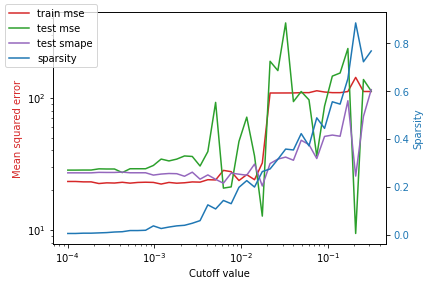

In [19]:
def smape(A, F):
    return 1/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))


cutoffs = np.logspace(-4, -0.5, num=40)
sparsity = []
mses = []
test_mses = []
smapes = []
all_weights = []
best_weights = {'smape': (None, 1e25, 0),
               'test_mse': (None, 1e25, 0),
               'train_mse': (None, 1e25, 0)}
for k in tqdm(cutoffs, ncols=50):
    weights, _ = sparse_regression(X.values, m2[poly_args['predicted_variables']].values, cutoff=k)
    mse = ((tf.matmul(tf.cast(X.values, dtype=tf.float32), tf.cast(weights, dtype=tf.float32)) - m2[poly_args['predicted_variables']].values)**2).numpy().mean()
    mses.append(mse)
    test_predictions = tf.matmul(tf.cast(X_test.values, dtype=tf.float32), tf.cast(weights, dtype=tf.float32))
    test_mse = ((test_predictions - test_m2[poly_args['predicted_variables']].values)**2).numpy().mean()
    test_mses.append(test_mse)
    sparsity.append((weights.numpy() == 0).sum()/len(weights.numpy().flatten()))
    current_smape = smape(test_predictions, test_m2[poly_args['predicted_variables']].values)
    smapes.append(current_smape)
    all_weights.append(weights)
    if test_mse <= best_weights['test_mse'][1]:
        best_weights['test_mse'] = weights, test_mse, k
    if mse <= best_weights['train_mse'][1]:
        best_weights['train_mse'] = weights, mse, k
    if current_smape <= best_weights['smape'][1]:
        best_weights['smape'] = weights, current_smape, k

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Cutoff value')
ax1.set_ylabel('Mean squared error', color=color)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.plot(cutoffs, mses, color=color, label='train mse')
ax1.plot(cutoffs, test_mses, color='tab:green', label='test mse')
ax1.tick_params(axis='y')

handles, labels = ax1.get_legend_handles_labels()

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Sparsity', color=color)  # we already handled the x-label with ax1
ax2.plot(cutoffs, smapes, color='tab:purple', label='test smape')
ax2.plot(cutoffs, sparsity, color=color, label='sparsity')
ax2.set_xscale('log')
ax2.tick_params(axis='y', labelcolor=color)
handles2, labels2 = ax2.get_legend_handles_labels()
handles += handles2
labels += labels2

fig.legend(handles, labels, loc='upper left')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [24]:
weights, _ = sparse_regression(X.values, m2[poly_args['predicted_variables']].values, cutoff=2e-3)
integration_args['weights'] = weights

# integration_args['weights'] = best_weights['smape'][0]

# weights = integration_args['weights']


mse = ((tf.matmul(tf.cast(X.values, dtype=tf.float32), weights) - m2[poly_args['predicted_variables']].values)**2).numpy().mean()

mse, (weights.numpy() != 0).sum(), weights

# show_weights(weights, derivative=False)

(22.60379,
 788,
 <tf.Tensor: shape=(820, 1), dtype=float32, numpy=
 array([[ 0.02772072],
        [-0.05573121],
        [ 0.4190184 ],
        [ 0.0088224 ],
        [-0.14963295],
        [-0.03428838],
        [-0.3091313 ],
        [-0.17517439],
        [ 0.51705426],
        [-0.27501798],
        [-0.00762883],
        [-0.3840522 ],
        [ 0.4318901 ],
        [ 0.2953751 ],
        [ 0.22800626],
        [-0.0099854 ],
        [ 0.06321436],
        [ 0.7883532 ],
        [-0.59316796],
        [ 0.03143546],
        [ 0.35977638],
        [ 0.6036892 ],
        [ 0.17835987],
        [ 0.07333608],
        [ 0.06694771],
        [-0.05950932],
        [-0.10020112],
        [-0.38073048],
        [ 0.33763477],
        [ 0.44085938],
        [-0.28731117],
        [ 0.22108504],
        [-0.17122008],
        [ 0.12857307],
        [-0.04829556],
        [-0.17795782],
        [ 0.06125401],
        [-0.07751906],
        [-0.18791729],
        [-0.28113416],
        [ 0.

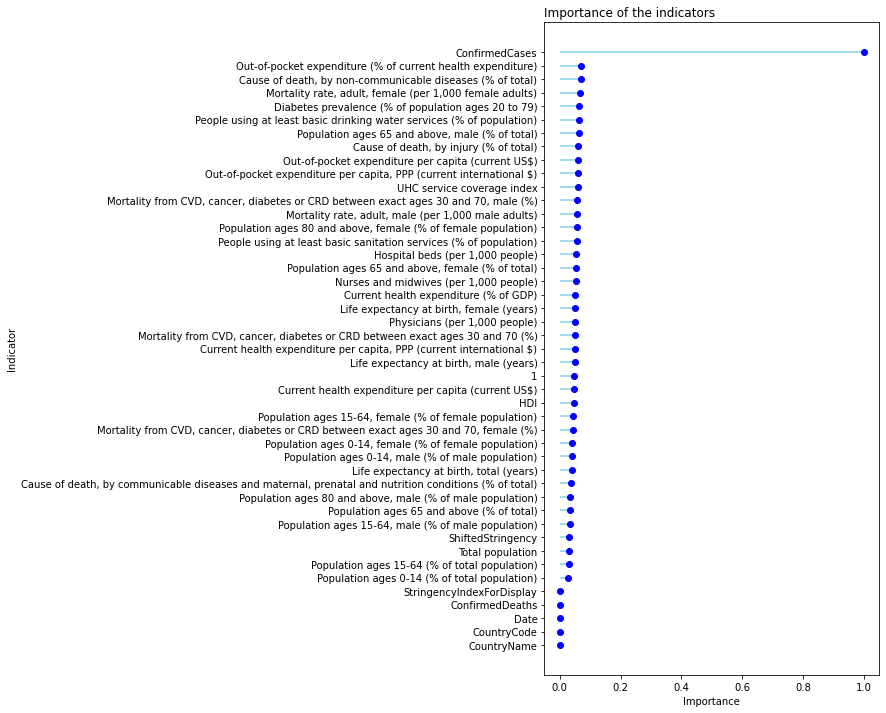

In [21]:
coefficients = [a.split('*') for a in X.columns]
masses = []
indics = [] 

plot_weights = weights

for indicator in m1.columns:
    weight = 0
    for coefs, w in zip(coefficients, plot_weights):
        if indicator in coefs:
            weight += abs(w.numpy()[0])
    masses.append(weight)
    if indicator in indicators_description.keys():
        indics.append(indicators_description[indicator])
    else:
        indics.append(indicator)
        
masses = np.array(masses)
    
plt.figure(figsize=(6, 12))
# Create a dataframe
df = pd.DataFrame({'group':indics, 'codes': m1.columns, 'values':masses})
df['values'] = (df['values']-df['values'].min())/(df['values'].max()-df['values'].min()) # normalization


ordered_df = df.sort_values(by='values')
ordered_df
my_range=range(1,len(df.index)+1)
 
# The vertival plot is made using the hline function
# I load the seaborn library only to benefit the nice looking feature
import seaborn as sns
plt.hlines(y=my_range, xmin=0, xmax=ordered_df['values'], color='skyblue')
plt.plot(ordered_df['values'], my_range, "o", color='blue')
 
# Add titles and axis names
plt.yticks(my_range, ordered_df['group'])
plt.title("Importance of the indicators", loc='left')
plt.xlabel('Importance')
plt.ylabel('Indicator')
plt.savefig('reports/importances.png')
plt.show()

In [30]:
ordered_df.iloc[:]['group'].values

array(['CountryName', 'CountryCode', 'Date', 'ConfirmedDeaths',
       'StringencyIndexForDisplay',
       'Population ages 0-14 (% of total population)',
       'Population ages 15-64 (% of total population)',
       'Total population', 'ShiftedStringency',
       'Population ages 15-64, male (% of male population)',
       'Population ages 65 and above (% of total)',
       'Population ages 80 and above, male (% of male population)',
       'Cause of death, by communicable diseases and maternal, prenatal and nutrition conditions (% of total)',
       'Life expectancy at birth, total (years)',
       'Population ages 0-14, male (% of male population)',
       'Population ages 0-14, female (% of female population)',
       'Mortality from CVD, cancer, diabetes or CRD between exact ages 30 and 70, female (%)',
       'Population ages 15-64, female (% of female population)', 'HDI',
       'Current health expenditure per capita (current US$)', '1',
       'Life expectancy at birth, male (

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [01:27<00:00,  2.20s/it]


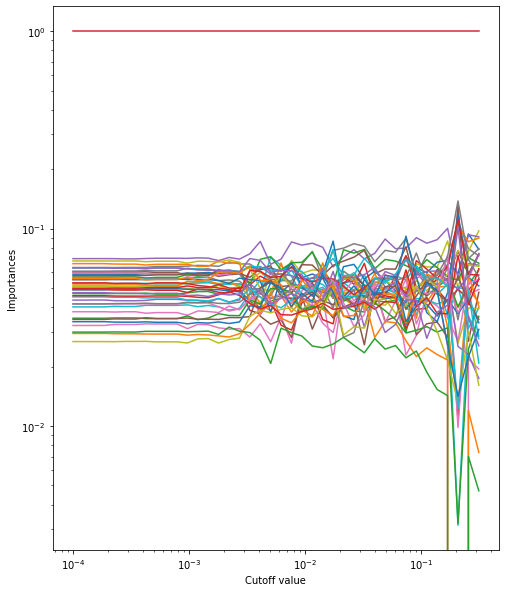

In [26]:
coefficients = [a.split('*') for a in X.columns]
importances = []
indics = [] 

for _weights in tqdm(all_weights):
    current_importances = []
    for indicator in m1.columns:
        weight = 0
        for coefs, w in zip(coefficients, _weights):
            if indicator in coefs:
                weight += abs(w.numpy()[0])
        current_importances.append(weight)
    importances.append(np.array(current_importances)/max(current_importances))
importances = np.array(importances)
plt.figure(figsize=(8, 10))
plt.plot(cutoffs, importances)
plt.xlabel('Cutoff value')
plt.ylabel('Importances')
plt.yscale('log')
plt.xscale('log')
plt.show()

In [31]:
list(X.columns)

['1*1*ConfirmedCases',
 '1*ConfirmedCases*ConfirmedCases',
 '1*ConfirmedCases*ShiftedStringency',
 '1*ConfirmedCases*SH.MED.BEDS.ZS',
 '1*ConfirmedCases*SH.MED.PHYS.ZS',
 '1*ConfirmedCases*SH.MED.NUMW.P3',
 '1*ConfirmedCases*SH.UHC.SRVS.CV.XD',
 '1*ConfirmedCases*SH.XPD.CHEX.GD.ZS',
 '1*ConfirmedCases*SH.XPD.CHEX.PC.CD',
 '1*ConfirmedCases*SH.XPD.CHEX.PP.CD',
 '1*ConfirmedCases*SH.XPD.OOPC.CH.ZS',
 '1*ConfirmedCases*SH.XPD.OOPC.PC.CD',
 '1*ConfirmedCases*SH.XPD.OOPC.PP.CD',
 '1*ConfirmedCases*SH.STA.DIAB.ZS',
 '1*ConfirmedCases*SP.DYN.LE00.FE.IN',
 '1*ConfirmedCases*SP.DYN.LE00.IN',
 '1*ConfirmedCases*SP.DYN.LE00.MA.IN',
 '1*ConfirmedCases*SP.DYN.AMRT.FE',
 '1*ConfirmedCases*SP.DYN.AMRT.MA',
 '1*ConfirmedCases*SH.DYN.NCOM.ZS',
 '1*ConfirmedCases*SH.DYN.NCOM.FE.ZS',
 '1*ConfirmedCases*SH.DYN.NCOM.MA.ZS',
 '1*ConfirmedCases*SH.DTH.COMM.ZS',
 '1*ConfirmedCases*SH.DTH.INJR.ZS',
 '1*ConfirmedCases*SH.DTH.NCOM.ZS',
 '1*ConfirmedCases*SH.H2O.BASW.ZS',
 '1*ConfirmedCases*SH.STA.BASS.ZS',
 '1*C

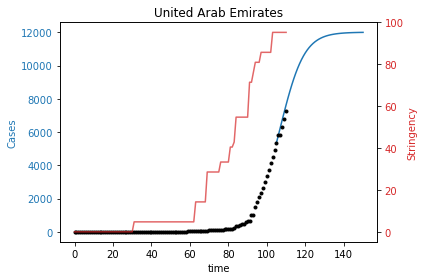

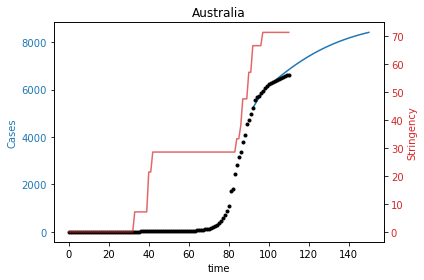

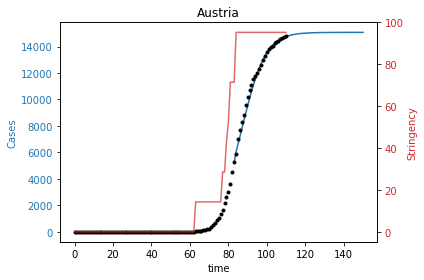

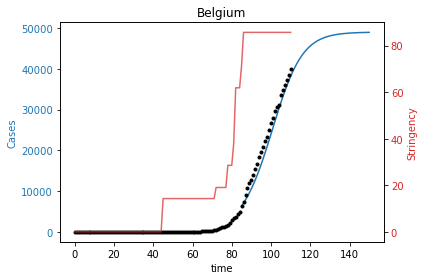

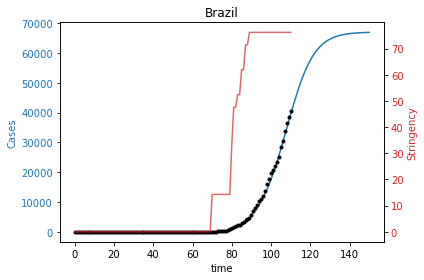

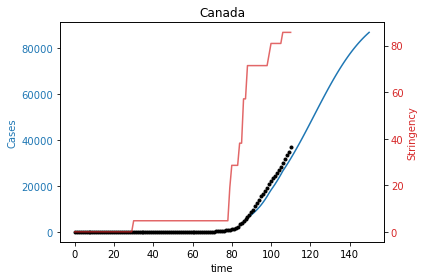

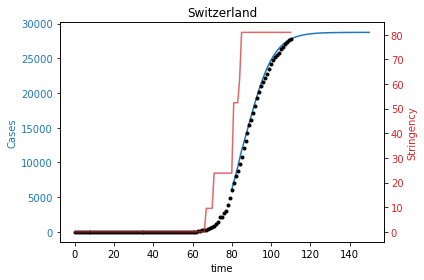

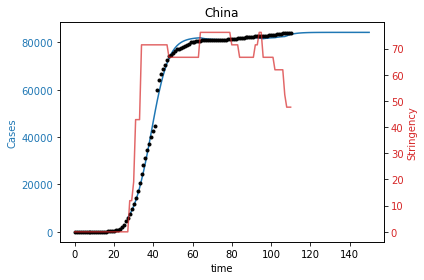

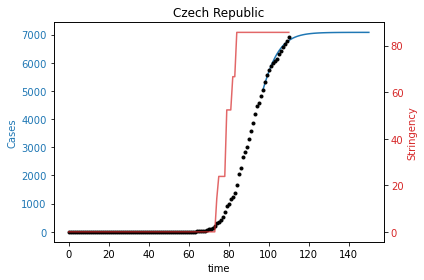

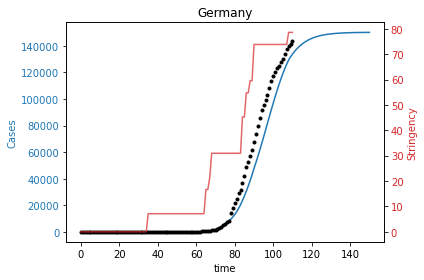

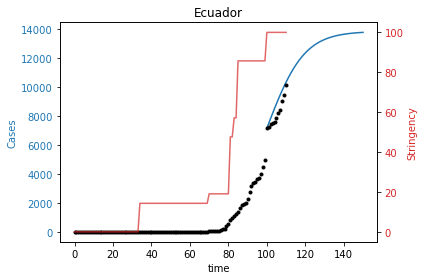

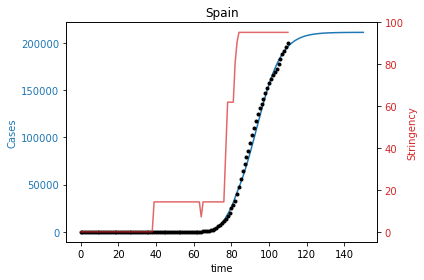

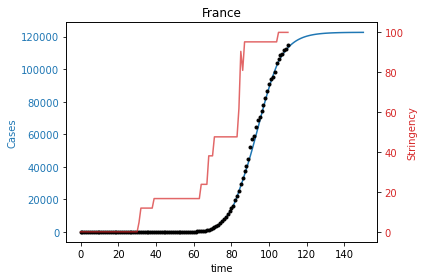

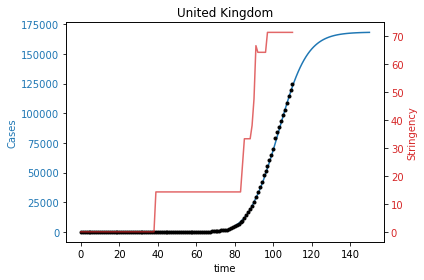

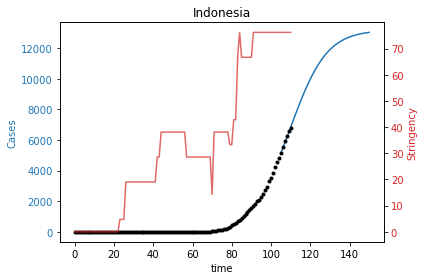

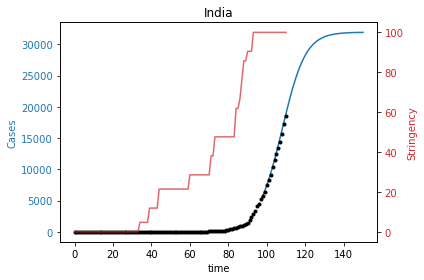

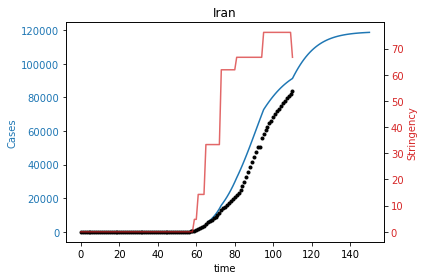

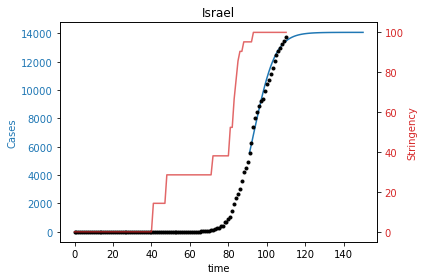

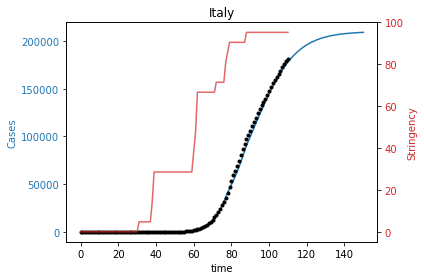

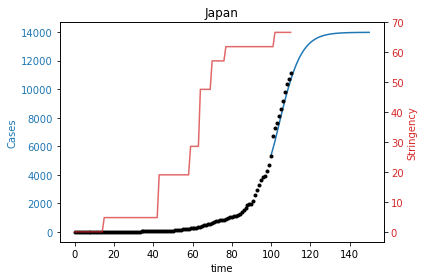

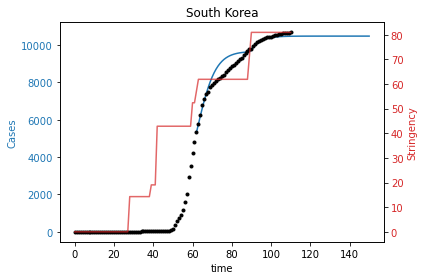

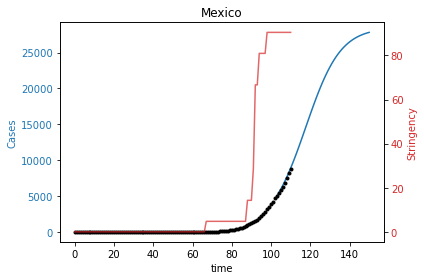

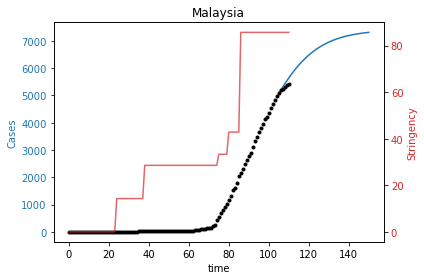

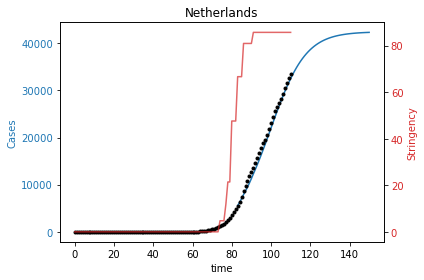

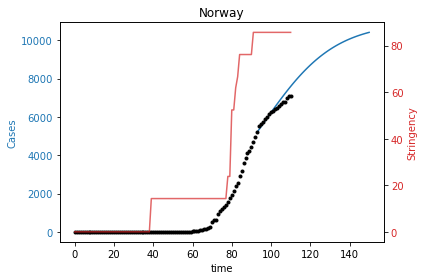

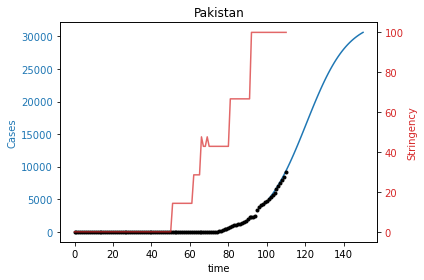

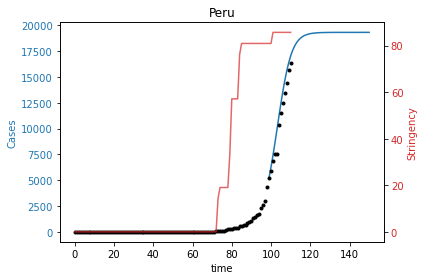

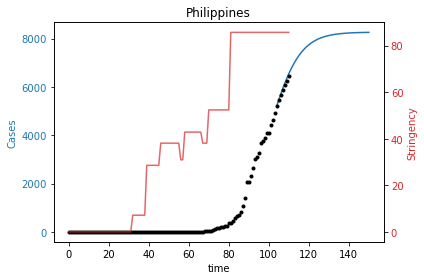

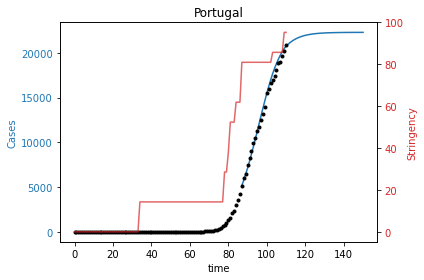

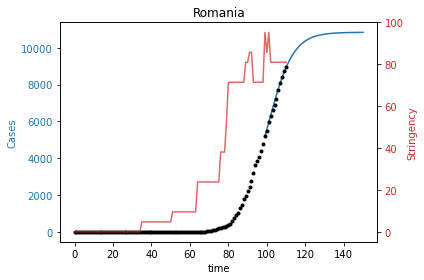

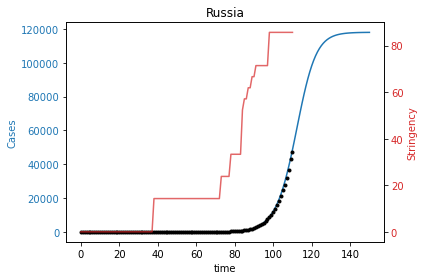

C:\Users\kipr\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
<ipython-input-25-ff24d073399c>:26: RuntimeWarning: invalid value encountered in matmul
  predicted_values.append(current_filter @ constant_terms)


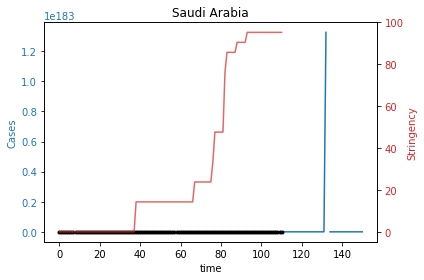

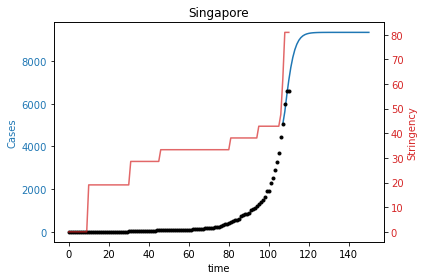

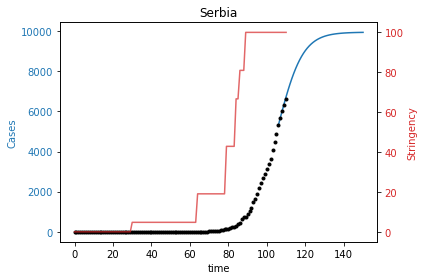

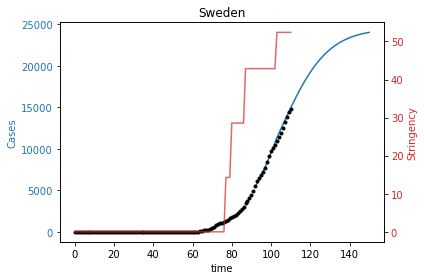

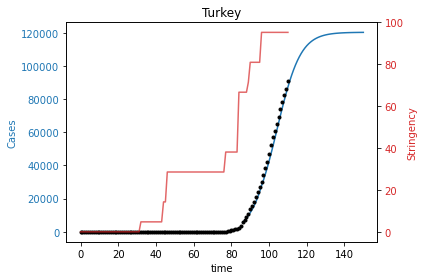

C:\Users\kipr\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
<ipython-input-25-ff24d073399c>:26: RuntimeWarning: invalid value encountered in matmul
  predicted_values.append(current_filter @ constant_terms)


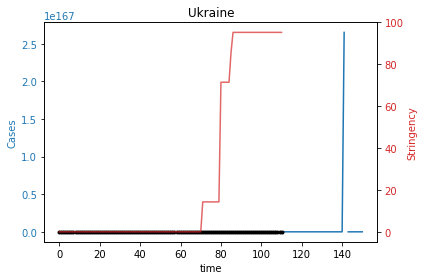

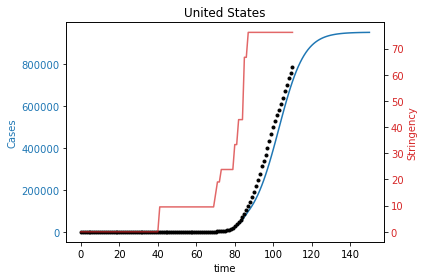

In [25]:

def integrate_df(real_trajectory, 
                 variables, 
                 predicted_variables, 
                 sparse_filters,
                 time_dependent_variables,
                 constant_variables,
                 weights,
                 extrapolation=50, 
                 max_degree=2):
    real_trajectory = real_trajectory.append(real_trajectory.iloc[[-1]*extrapolation]).reset_index(drop=True)
    
    constant_terms = [real_trajectory.iloc[[0]].loc[:, inds].values.prod() for inds in constant_variables]
    
    constant_terms = np.multiply(np.array(constant_terms).reshape(-1, 1), weights)
    predicted_values = [real_trajectory.iloc[0][predicted_variables].values]
    not_predicted_time_dependent = real_trajectory[[a for a in time_dependent_variables if a not in predicted_variables]].values
    
    def time_dependent_terms(k):
        current_filter = sparse_filters.copy()
        values = list(predicted_values[k]) + list(not_predicted_time_dependent[k])
        for i, val in enumerate(values):
            current_filter[:, i*max_degree:(i + 1)*max_degree] *= val
        return np.nanprod(current_filter, axis=1)
    for k in range(len(real_trajectory.index) - 1):
        current_filter = time_dependent_terms(k)
        predicted_values.append(current_filter @ constant_terms)
    return np.array(predicted_values)
        

for country in train_countries:
    country_data = data[data['CountryName'] == country]
    t = range(len(country_data.index) + (extrapolation:=40))
    high_data = data[(data['CountryName'] == country) & (data['ConfirmedCases'] > 50)]
    real_t = len(high_data.index)
    if real_t:
        guess = integrate_df(real_trajectory=high_data, extrapolation=extrapolation, **integration_args, **poly_args)
        # plt.plot(t[-real_t-extrapolation:], guess[:, 0]*rescaling, label='predictions')
        # plt.plot(t[:-extrapolation], country_data['ConfirmedCases']*rescaling, 'k.', label='real data')
        # plt.legend()
        # plt.title(country)
        # plt.show()
        
        fig, ax1 = plt.subplots()
        color = 'tab:blue'
        ax1.set_xlabel('time')
        ax1.set_ylabel('Cases', color=color)
        ax1.plot(t[-real_t-extrapolation:], guess[:, 0]*rescaling, label='predictions')
        ax1.plot(t[:-extrapolation], country_data['ConfirmedCases']*rescaling, 'k.', label='real data')
        ax1.tick_params(axis='y', labelcolor=color)

        ax2 = ax1.twinx()

        color = 'tab:red'
        ax2.set_ylabel('Stringency', color=color)
        ax2.plot(t[:-extrapolation], country_data['ShiftedStringency'], color=color, alpha=0.7)
        ax2.tick_params(axis='y', labelcolor=color)
        plt.title(country)
        fig.tight_layout()
        plt.show()

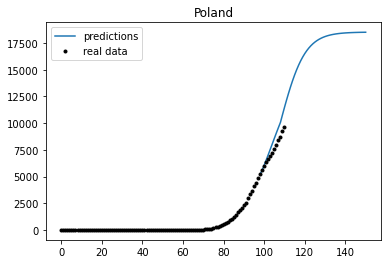

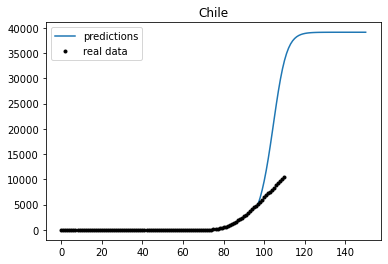

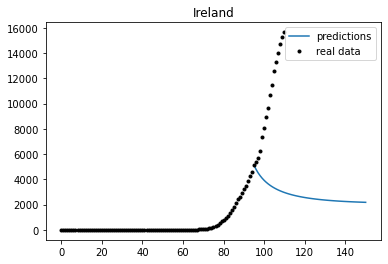

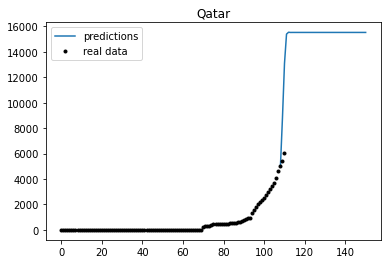

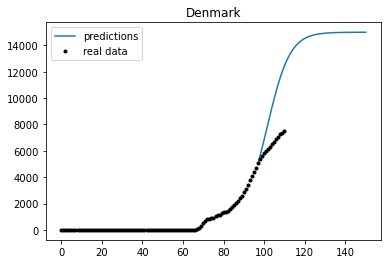

In [27]:
for country in test_countries:
    country_data = data[data['CountryName'] == country]
    t = range(len(country_data.index) + (extrapolation:=40))
    high_data = data[(data['CountryName'] == country) & (data['ConfirmedCases'] > 50)]
    real_t = len(high_data.index)
    if real_t:
        guess = integrate_df(real_trajectory=high_data, extrapolation=extrapolation, **integration_args, **poly_args)
        plt.plot(t[-real_t-extrapolation:], guess[:, 0]*rescaling, label='predictions')
        plt.plot(t[:-extrapolation], country_data['ConfirmedCases']*rescaling, 'k.', label='real data')
        plt.legend()
        plt.title(country)
        plt.show()

In [ ]:
from itertools import product
fig, axs = plt.subplots(3, 2, figsize=(12, 12))
for (a, b), country in zip(product([0, 1, 2], [0, 1]), ['Belgium', 'Brazil', 'China', 'France', 'India', 'Turkey']):
    country_data = data[data['CountryName'] == country]
    t = range(len(country_data.index) + (extrapolation:=40))
    high_data = data[(data['CountryName'] == country) & (data['ConfirmedCases'] > 50)]
    real_t = len(high_data.index)
    if real_t:
        guess = integrate_df(real_trajectory=high_data, extrapolation=extrapolation, **integration_args, **poly_args)
        axs[a, b].plot(t[-real_t-extrapolation:], guess[:, 0]*rescaling, label='predictions')
        axs[a, b].plot(t[:-extrapolation], country_data['ConfirmedCases']*rescaling, 'k.', label='real data')
        axs[a, b].legend()
        axs[a, b].set_title(country)
        if a == 2:
            axs[a, b].set(xlabel='time')
        if b == 0:
            axs[a, b].set(ylabel='cases')

plt.show()

In [ ]:
fig.savefig('reports/successful.png')

In [ ]:
from itertools import product
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
for (a, b), country in zip(product([0, 1], [0, 1]), ['Australia', 'Japan', 'Chile', 'Denmark']):
    country_data = data[data['CountryName'] == country]
    t = range(len(country_data.index) + (extrapolation:=40))
    high_data = data[(data['CountryName'] == country) & (data['ConfirmedCases'] > 50)]
    real_t = len(high_data.index)
    if real_t:
        guess = integrate_df(real_trajectory=high_data, extrapolation=extrapolation, **integration_args, **poly_args)
        axs[a, b].plot(t[-real_t-extrapolation:], guess[:, 0], label='predictions')
        axs[a, b].plot(t[:-extrapolation], country_data['ConfirmedCases'], 'k.', label='real data')
        axs[a, b].legend()
        axs[a, b].set_title(country)
        if a == 1:
            axs[a, b].set(xlabel='time')
        if b == 0:
            axs[a, b].set(ylabel='cases')


plt.show()

In [ ]:
fig.savefig('reports/unsuccessful.png')

## Logistic predictions

In [ ]:
# data = pd.read_csv('C:/Users/kipr/Downloads/téléchargement.csv')
tmp = data[data['popData2018'] > 1e7]
countries = tmp['countriesAndTerritories'].unique()
countries

In [ ]:
results = []
for country in countries:
    country_data = data[data['countriesAndTerritories'] == country].copy()
    country_data.loc[:, 'dateRep'] = pd.to_datetime(country_data['dateRep'], dayfirst=True)
    values = country_data.sort_values('dateRep')[['cases', 'deaths', 'popData2018', 'dateRep']]
    # print(values)
    if len(values.index) > 1:
        date = values['dateRep'].values[0]
        values = np.cumsum(values['cases'])
        beginning = find_beginning(values)
        date = date + pd.to_timedelta(beginning, unit='D')
        values = values[beginning:]
        if len(values) < 10 or max(values) < 500:
            continue
        popt, pcov = curve_fit(logistic, (t:=range(len(values))), values/max(values), 
                               maxfev=10000)
        sol = logistic(t, *popt)*max(values)
        print(((values-sol)**2).mean())
        final_value = logistic(400, *popt)*max(values)
        if final_value < country_data['popData2018'].values[0]:# and popt[0] < 10000:
            plt.plot(t, values, 'k.')
            plt.plot(range(len(t)*2), logistic(range(len(t)*2), *popt)*max(values))
            plt.title(country)
            plt.show()
            results.append([country, date, final_value] + list(popt))
results = pd.DataFrame(results, columns=['country', 'start_date', 'final_number', 'a', 'b', 'c'])
results

In [ ]:
results['final_number'].sum()

In [ ]:
results['country'].values

In [ ]:
results.to_csv('predictions_08-04-2020.csv', index=False)

In [ ]:
old_data = pd.read_csv('https://opendata.ecdc.europa.eu/covid19/casedistribution/csv')



In [ ]:
# iso = {}
# for country in countries:
#     try:
#         iso[country] = name_to_iso3[country]
#     except KeyError:
#         found = False
#         for alias in aliases[country]:
#             try:
#                 iso[country] = name_to_iso3[alias]
#                 found = True
#                 break
#             except KeyError:
#                 pass
#         if not found:
#             iso[country] = input(country)
# iso


# capitals = pd.read_html('https://en.wikipedia.org/wiki/List_of_national_capitals_by_latitude')[1].drop_duplicates('Country')
# capitals = capitals.set_index('Country', drop=True)['Latitude("−" indicates southern hemisphere)']

# lattitudes = {}

# for country in countries:
#     try:
#         lattitudes[country] = float(capitals[country].replace('−', '-'))
#     except KeyError:
#         found = False
#         for alias in aliases[country]:
#             try:
#                 lattitudes[country] = float(capitals[alias].replace('−', '-'))
#                 found = True
#                 break
#             except KeyError:
#                 continue
#         if not found:
#             raise KeyError

# rescaling = 10000
# pop_rescaling = 10000000

# trajectories = []
# for country in countries:
#     country_data = data[data['countriesAndTerritories'] == country].copy()
#     country_data.loc[:, 'dateRep'] = pd.to_datetime(country_data['dateRep'], dayfirst=True)
#     values = country_data.sort_values('dateRep')[['cases', 'popData2018']]
#     values['cases'] = np.cumsum(values['cases'])
#     # values = values.drop(columns=['popData2018'])
#     values['popData2018'] = values['popData2018']/pop_rescaling
#     values['hdi'] = hdis[country]*100
#     values['latitude'] = lattitudes[country]
#     for ind, val in zip(indicators, result[country]):
#         values[ind] = val
#     beginning = find_beginning(values['cases'])
#     values = values[beginning:]/rescaling
#     if not values.empty:
#         trajectories.append(values.values)
    
# trajectories = np.array(trajectories)

# hdi = pd.read_csv('C:/Users/kipr/Downloads/Human development index (HDI).csv')[['Country', '2018']].set_index('Country')
# list(hdi.index)
# hdi = pd.read_csv('C:/Users/kipr/Downloads/Human development index (HDI).csv')[['Country', '2018']].set_index('Country')
# hdi['2018'] = hdi['2018'].astype(np.float32, errors='ignore')

# hdis = {}
# for country, iso in countries.items():
#     try:
#         hdis[iso] = float(hdis_old[iso])
#     except ValueError:
#         hdis[iso] = np.nan


# with open('C:/Users/kipr/Downloads/covid-indicators.json') as json_file:
#     inds = json.load(json_file)

# indicators = []
# indicators_description = {}
# for topic in inds:
#     inds = list(topic['indicators'].keys())
#     indicators += inds
#     for ind in inds:
#         indicators_description[ind]= topic['indicators'][ind]